# Δ-Motif Tutorial: Part 1 - Graphs as Tables

## Learning Objectives

By the end of this notebook, you will:
1. Understand the **subgraph isomorphism** problem
2. See why traditional algorithms like **VF2** have limitations
3. Learn the key insight: **graphs can be represented as tables**
4. Build a simplified **Δ-Motif algorithm** from scratch using Pandas
5. Benchmark and compare performance

**Time: 15-25 minutes**

---
## 1. Setup & Introduction

### What is Subgraph Isomorphism?

**Problem**: Given a large graph (data graph) and a small pattern graph, find **all** occurrences of the pattern within the data graph.

**Real-world applications**:
- 🧬 Finding molecular structures in drug discovery
- 👥 Detecting communities in social networks
- 🔒 Identifying attack patterns in cybersecurity
- ⚛️ Mapping quantum circuits to hardware (our focus!)

**Challenge**: This is an NP-complete problem - traditional algorithms don't scale well!

In [1]:
# Install dependencies (uncomment if needed)
# !pip install rustworkx pandas numpy matplotlib seaborn

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time, perf_counter
from typing import List, Tuple, Set

# Import utility functions
from utils import create_example_graph,gen_edge_colors

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"📦 rustworkx version: {rx.__version__}")
print(f"📦 pandas version: {pd.__version__}")

✅ All libraries imported successfully!
📦 rustworkx version: 0.17.1
📦 pandas version: 2.0.0


---
## 2. Building and Visualizing Graphs with rustworkx

### What is rustworkx?

**rustworkx** (formerly retworkx) is a high-performance graph library for Python written in Rust. It provides:
- **Fast execution**: Core algorithms written in Rust for performance
- **Easy to use**: Pythonic API similar to NetworkX
- **Rich functionality**: Comprehensive set of graph algorithms
- **Multiple graph types**: Directed and undirected graphs

### Why rustworkx?
- **Performance**: 10-100x faster than pure Python implementations
- **Memory efficient**: Rust's memory management
- **Battle-tested**: Used by Qiskit and other production systems
- **Active development**: Regular updates and improvements

Let's explore what we can do with rustworkx!

### 2.1 rustworkx Basics: Creating and Querying Graphs

rustworkx supports **PyGraph** (undirected) and **PyDiGraph** (directed) graphs. Let's see how to create and work with them:

In [31]:
# Creating a graph and adding nodes/edges
g = rx.PyGraph()

# Add nodes (returns node index)
n0 = g.add_node("A")
n1 = g.add_node("B")
n2 = g.add_node("C")
n3 = g.add_node("D")

# Add edges
g.add_edge(n0, n1, "A-B")
g.add_edge(n1, n2, "B-C")
g.add_edge(n2, n0, "C-A")  # Creates a triangle
g.add_edge(n2, n3, "C-D")

print("📊 Graph Properties:")
print(f"   Nodes: {g.num_nodes()}, Edges: {g.num_edges()}")
print(f"   Node list: {[g[i] for i in g.node_indices()]}")
print(f"   Edge list: {g.edge_list()}")

# Querying the graph
print(f"\n🔍 Querying the graph:")
print(f"   Neighbors of node 2 (C): {g.neighbors(2)}")
print(f"   Degree of node 2: {g.degree(2)}")
print(f"   Edge exists (0,1)? {g.has_edge(0, 1)}")

# Common graph generators
print(f"\n🔧 Quick graph creation:")
triangle = rx.generators.cycle_graph(3)  # 3-node cycle
complete = rx.generators.complete_graph(4)  # All nodes connected
random_g = rx.undirected_gnp_random_graph(10, 0.3, seed=42)  # Random graph
print(f"   Triangle: {triangle.num_nodes()} nodes, {triangle.num_edges()} edges")
print(f"   Complete K4: {complete.num_nodes()} nodes, {complete.num_edges()} edges")
print(f"   Random (n=10, p=0.3): {random_g.num_nodes()} nodes, {random_g.num_edges()} edges")

📊 Graph Properties:
   Nodes: 4, Edges: 4
   Node list: ['A', 'B', 'C', 'D']
   Edge list: EdgeList[(0, 1), (1, 2), (2, 0), (2, 3)]

🔍 Querying the graph:
   Neighbors of node 2 (C): NodeIndices[1, 0, 3]
   Degree of node 2: 3
   Edge exists (0,1)? True

🔧 Quick graph creation:
   Triangle: 3 nodes, 3 edges
   Complete K4: 4 nodes, 6 edges
   Random (n=10, p=0.3): 10 nodes, 13 edges


### 2.2 Useful Graph Algorithms in rustworkx

rustworkx includes many built-in algorithms. Here are a few commonly used ones:

In [40]:
# Create a sample graph for demonstrations
demo = rx.PyGraph()
for i in range(7):
    demo.add_node(i)
demo.add_edges_from_no_data([(0,1), (0,2), (1,2), (1,3), (2,4), (3,5), (4,5), (5,6)])

print("rustworkx Algorithms:\n")

# Shortest path
path = rx.dijkstra_shortest_paths(demo, 0, target=6, weight_fn=lambda e: 1)
print(f"1️⃣  Shortest path (0→6): {path[6]}")

# Connected components
components = rx.connected_components(demo)
print(f"2️⃣  Connected components: {len(components)} component(s)")

# Centrality (which nodes are most important?)
centrality = rx.betweenness_centrality(demo)
most_central = max(centrality.items(), key=lambda x: x[1])
print(f"3️⃣  Most central node: {most_central[0]} (betweenness={most_central[1]:.2f})")

# Cycle detection
has_cycle = rx.is_connected(demo)
print(f"4️⃣  Is connected: {has_cycle}")

algo_names = "\n".join([name for name in dir(rx) if 'centrality' in name][:5])
print(f"\n💡 More algorithms available: {algo_names}")
print("🔗 See the rustworkx documentation for a full list:")
print("https://www.rustworkx.org/api/algorithm_functions/index.html")

rustworkx Algorithms:

1️⃣  Shortest path (0→6): NodeIndices[0, 2, 4, 5, 6]
2️⃣  Connected components: 1 component(s)
3️⃣  Most central node: 5 (betweenness=0.40)
4️⃣  Is connected: True

💡 More algorithms available: betweenness_centrality
closeness_centrality
degree_centrality
digraph_betweenness_centrality
digraph_closeness_centrality
🔗 See the rustworkx documentation for a full list:
https://www.rustworkx.org/api/algorithm_functions/index.html


### 🎯 Exercise: Explore Graph Algorithms

**Algorithms to use**:
- `rx.dijkstra_shortest_paths(graph, source, target)` - Find shortest path between two nodes
- `rx.betweenness_centrality(graph)` - Measure node importance (returns dict: node → centrality score)
- `rx.connected_components(graph)` - Find connected subgraphs (returns list of node sets)
- `rx.is_connected(graph)` - Check if entire graph is connected

**Your task**: Use the graph below to answer these questions:
1. What is the shortest path from node 0 to node 9?
2. Which node is most central (highest betweenness centrality)?
3. How many connected components are in this graph?
4. Is the graph fully connected?

In [ ]:
# Create an interesting graph to explore
exercise_graph = rx.generators.binomial_tree_graph(10)  # A tree with interesting structure

# Visualize it
mpl_draw(exercise_graph, with_labels=True, node_size=800, node_color='lightcoral')
plt.title(f"Exercise Graph ({exercise_graph.num_nodes()} nodes, {exercise_graph.num_edges()} edges)")
plt.show()

# YOUR CODE HERE - Use rustworkx algorithms to answer the questions above
# Example:
# path = rx.dijkstra_shortest_paths(exercise_graph, 0, target=9, weight_fn=lambda e: 1)
# print(f"Shortest path: {path[9]}")



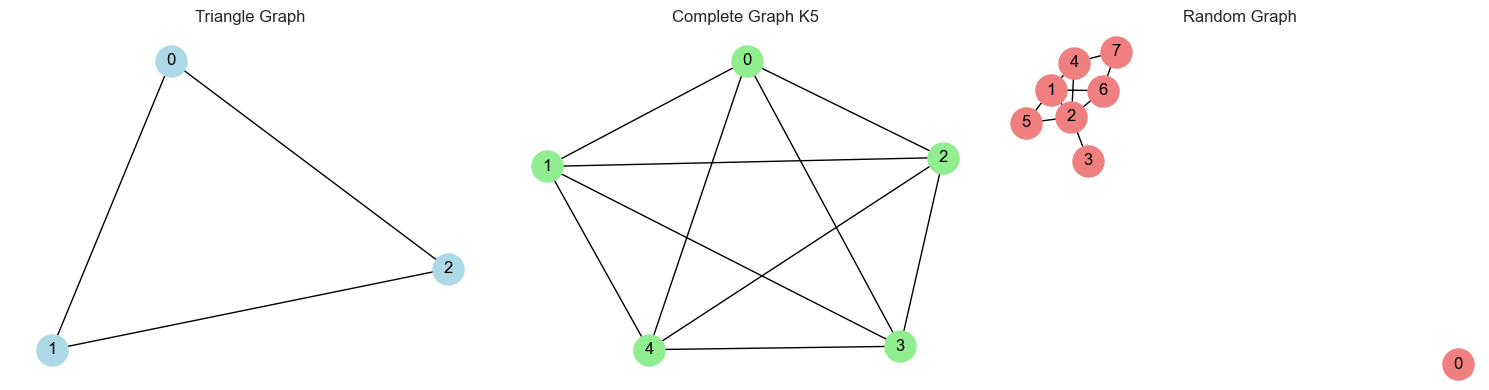

In [47]:
# Create a few simple graphs to visualize with matplotlib
from rustworkx.visualization import mpl_draw

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Triangle
triangle_g = rx.generators.cycle_graph(3)
mpl_draw(triangle_g, ax=axes[0], with_labels=True, node_color='lightblue', node_size=500)
axes[0].set_title("Triangle Graph")

# 2. Complete graph K5
k5 = rx.generators.complete_graph(5)
mpl_draw(k5, ax=axes[1], with_labels=True, node_color='lightgreen', node_size=500)
axes[1].set_title("Complete Graph K5")

# 3. Small random graph
random_small = rx.undirected_gnp_random_graph(8, 0.35, seed=123)
mpl_draw(random_small, ax=axes[2], with_labels=True, node_color='lightcoral', node_size=500)
axes[2].set_title("Random Graph")

plt.tight_layout()
plt.show()

## Your turn, use rustworkx to create and visualize your own graph!
- There is a larget data set in utils.py::load_facebook_dataset you can load and explore

In [2]:
from utils import load_facebook_dataset
fb_graph = load_facebook_dataset()
print(f"Facebook graph: {fb_graph.num_nodes()} nodes, {fb_graph.num_edges()} edges")

✅ Using cached dataset at data/facebook_combined.txt
📊 Loading graph...
✅ Loaded graph: 4039 nodes, 88234 edges
Facebook graph: 4039 nodes, 88234 edges


---
## 3. The Traditional Approach: VF2 Algorithm

VF2 is a classic algorithm for subgraph isomorphism. It uses a **depth-first search with backtracking** strategy.

**How VF2 works**:
1. Start with an empty mapping
2. Try to match pattern nodes one by one
3. At each step, check if the match is valid
4. If valid, continue; if not, backtrack
5. Repeat until all solutions are found

**Problem**: This is inherently sequential - hard to parallelize! ⚠️

In [48]:
# Create the graph using the utility function
data_graph = create_example_graph()

print(f"📊 Created graph with {data_graph.num_nodes()} nodes and {data_graph.num_edges()} edges")

📊 Created graph with 5 nodes and 6 edges


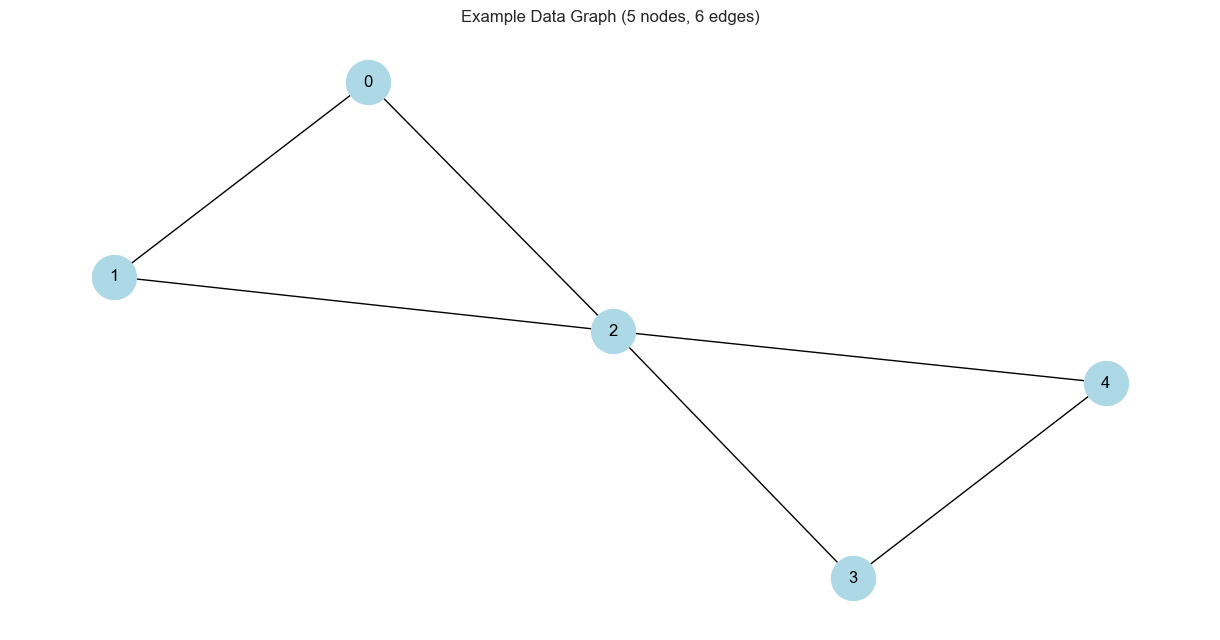

In [55]:
# Visualize the data graph
mpl_draw(data_graph, with_labels=True, node_size=1000, node_color='lightblue')
plt.title("Example Data Graph (5 nodes, 6 edges)")
plt.show()

**Question**: Can you spot the triangles in this graph? 🔍

*(Hint: Look for groups of 3 nodes that are all connected to each other)*

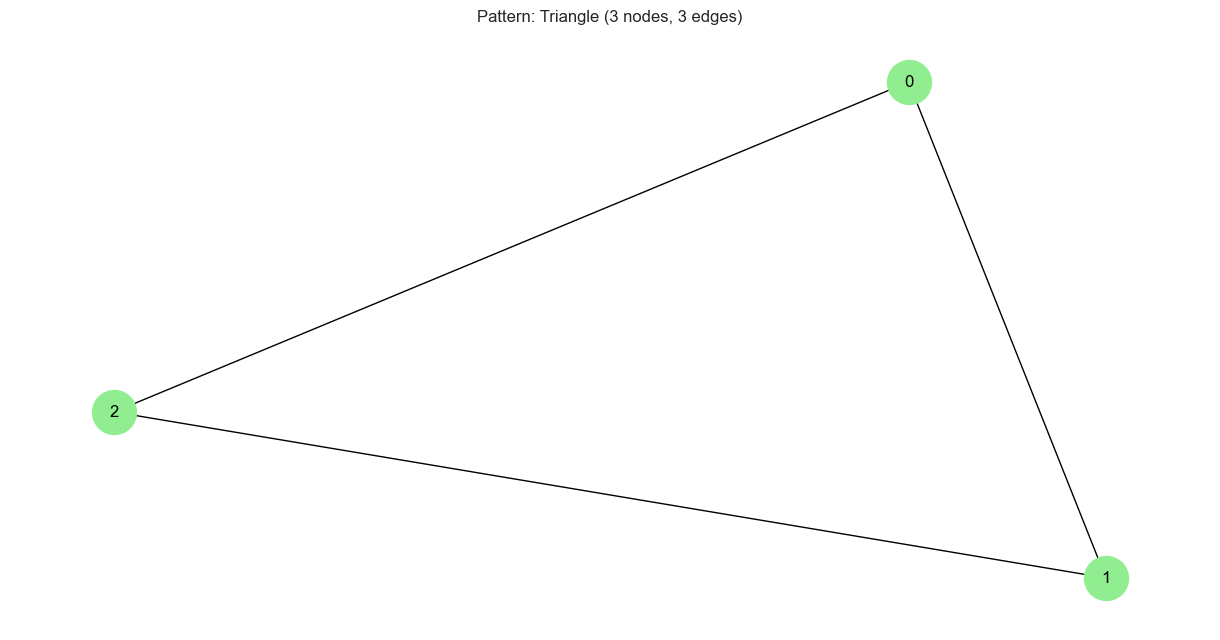

In [56]:
def create_triangle_pattern() -> rx.PyGraph:
    """
    Create a triangle pattern graph (3 nodes, 3 edges).
    """
    pattern = rx.PyGraph()
    
    # Add 3 nodes
    n0 = pattern.add_node(0)
    n1 = pattern.add_node(1)
    n2 = pattern.add_node(2)
    
    # Create triangle
    pattern.add_edge(n0, n1, None)
    pattern.add_edge(n1, n2, None)
    pattern.add_edge(n2, n0, None)
    
    return pattern

triangle_pattern = create_triangle_pattern()
mpl_draw(triangle_pattern, with_labels=True, node_size=1000, node_color='lightgreen')
plt.title("Pattern: Triangle (3 nodes, 3 edges)")
plt.show()

## The VF2 API in rustworkx
In rustworkx, the `vf2_mapping` function returns an iterator of matches.
Each match is a dictionary mapping pattern node indices to data graph node indices.
For example, a match like `{0: 1, 1: 2, 2: 3}` means:
- Pattern node 0 maps to data graph node 1
- Pattern node 1 maps to data graph node 2
- Pattern node 2 maps to data graph node 3
In our examples we will convert these dictionaries to lists of data graph node indices for easier visualization.

In [58]:
# Find all triangles using VF2
print("🔍 Finding all triangles using VF2...\n")

start_time = time()
vf2_matches_iterator = rx.vf2_mapping(data_graph, triangle_pattern, subgraph=True)
vf2_matches = list(vf2_matches_iterator)
vf2_time = time() - start_time

print(f"✅ VF2 found {len(vf2_matches)} triangles")
print(f"⏱️  Time: {vf2_time*1000:.3f} ms\n")

# Display the first few matches
print("First few triangle matches:")
for i, match in enumerate(vf2_matches[:10]):
    print(f"  Triangle {i+1}: nodes {list(match.values())}")

🔍 Finding all triangles using VF2...

✅ VF2 found 12 triangles
⏱️  Time: 0.150 ms

First few triangle matches:
  Triangle 1: nodes [0, 1, 2]
  Triangle 2: nodes [0, 1, 2]
  Triangle 3: nodes [0, 1, 2]
  Triangle 4: nodes [0, 1, 2]
  Triangle 5: nodes [0, 1, 2]
  Triangle 6: nodes [0, 1, 2]
  Triangle 7: nodes [0, 1, 2]
  Triangle 8: nodes [0, 1, 2]
  Triangle 9: nodes [0, 1, 2]
  Triangle 10: nodes [0, 1, 2]


First triangle match: nodes [0, 1, 2]


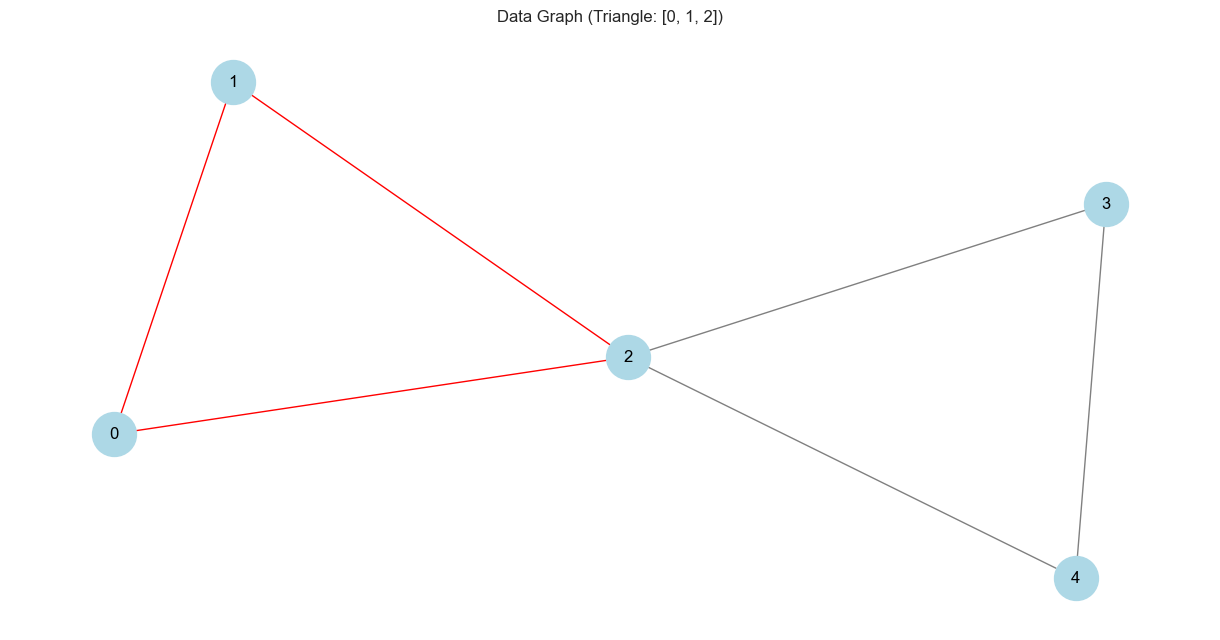

In [68]:
first_match = vf2_matches[0]
print(f"First triangle match: nodes {list(first_match.values())}")
mpl_draw(data_graph, with_labels=True, node_size=1000, node_color='lightblue',
         edge_color=gen_edge_colors(data_graph, first_match))
plt.title(f"Data Graph (Triangle: {list(first_match.values())})")
plt.show()

### 🎯 Exercise: Find Different Patterns with VF2

Now it's your turn! Use VF2 to find more complex patterns in a graph.

**Your tasks**:
1. Complete the pattern creation functions below (fill in the TODOs)
2. Use `rx.vf2_mapping()` to find all occurrences of each pattern
3. Count how many matches you find for each pattern

**Patterns to find**:
- **Star**: 1 center node connected to 3 outer nodes (3 edges total, no edges between outer nodes)

In [ ]:
# Create a larger graph to search in
exercise_graph = rx.undirected_gnp_random_graph(30, 0.25, seed=100)
print(f"📊 Exercise graph: {exercise_graph.num_nodes()} nodes, {exercise_graph.num_edges()} edges\n")

def create_star_pattern() -> rx.PyGraph:
    """Create a star: 1 center node connected to 2 outer nodes."""
    pattern = rx.PyGraph()
    # TODO: Add 4 nodes (1 center + 3 outer)
    # TODO: Add edges from center to each outer node (hint: 3 edges total)
    return pattern

# TODO: Create the patterns
# star_pattern = create_star_pattern()

# TODO: Use VF2 to find all matches

# TODO: Analyze your results

### VF2 Performance on Larger Graphs

Let's see how VF2 performs as graphs get bigger...

In [62]:
# Create larger graphs and benchmark VF2
sizes = [20, 30, 40, 50, 100, 200, 400]
vf2_times: dict[int, float] = {}

print("⏱️  Benchmarking VF2 on larger graphs...\n")

for size in sizes:
    large_graph = rx.undirected_gnp_random_graph(size, 0.15, seed=42)

    start = time()
    matches = list(rx.vf2_mapping(large_graph, triangle_pattern, subgraph=True))
    elapsed = time() - start
    
    vf2_times[size]=elapsed
    print(f"  Graph with {size} nodes: {len(matches)} triangles found in {elapsed*1000:.1f} ms")

print("\n⚠️  Notice: Runtime increases significantly with graph size!")

⏱️  Benchmarking VF2 on larger graphs...

  Graph with 20 nodes: 18 triangles found in 201.8 ms
  Graph with 30 nodes: 60 triangles found in 0.5 ms
  Graph with 40 nodes: 240 triangles found in 0.3 ms
  Graph with 50 nodes: 498 triangles found in 10.2 ms
  Graph with 100 nodes: 3558 triangles found in 10.9 ms
  Graph with 200 nodes: 25026 triangles found in 73.9 ms
  Graph with 400 nodes: 205650 triangles found in 1468.6 ms

⚠️  Notice: Runtime increases significantly with graph size!


---
## 4. The Key Insight: Graphs as Tables

### 💡 Core Idea

- Graph isomorphism can be seen as the union of small patterns. For example say we need to find triangles.
triangles is the union of 3 2-node paths connect in a cycle
The first thing we need to do is break down the graphs in all its 2-node paths, then find intersections between those paths.
Finally find edges that connect the start and the of those paths


📊 Edge List of the Data Graph: [(0, 1), (2, 4), (1, 2), (2, 1), (3, 4), (4, 3), (2, 0), (4, 2), (2, 3), (0, 2), (1, 0), (3, 2)]


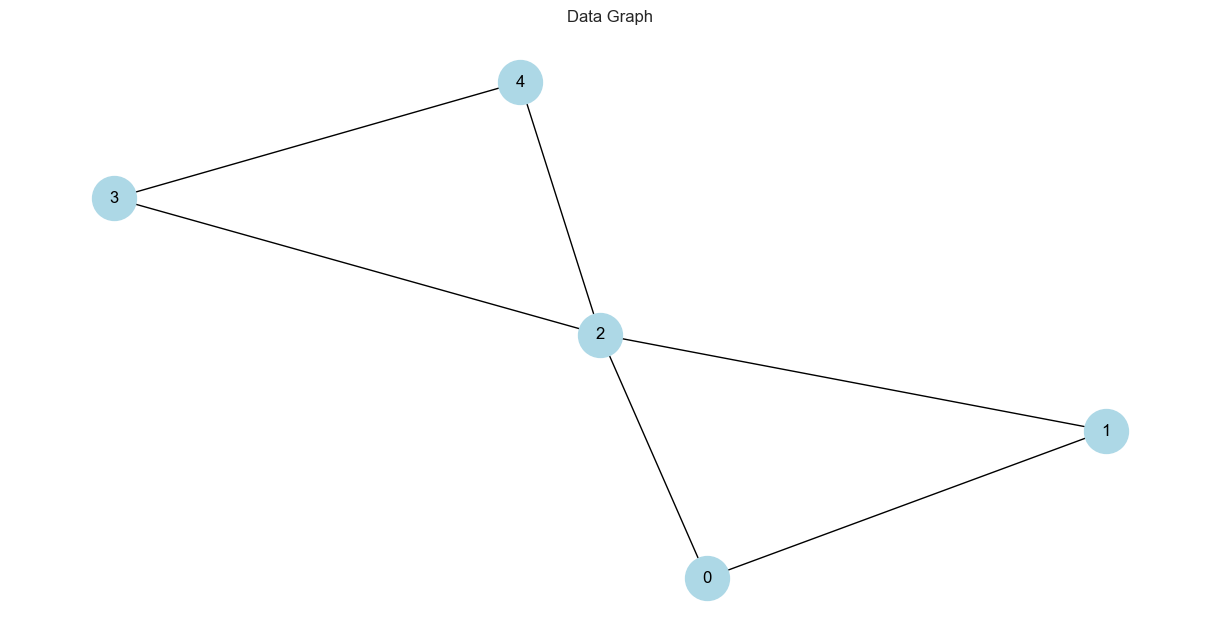

In [63]:
def create_edge_list(graph: rx.PyGraph) -> List[Tuple[int, int]]:
    """
    Create an edge list from the graph.
    Each edge is represented as a tuple (src, dst).
    """
    result = set()
    for x, y in graph.edge_list():
        result.add((x, y))
        result.add((y, x))
    return list(result)

edge_list = create_edge_list(data_graph)
print(f"📊 Edge List of the Data Graph: {edge_list}")
mpl_draw(data_graph, with_labels=True, node_size=1000, node_color='lightblue')
plt.title("Data Graph")
plt.show()

#### 3-node paths
Ok give the edge list we have find all the 3 node paths in the graph,
notice that 2-node paths are simply just edges.


📊 Found 6 2-node paths in the graph.
First few 2-node paths: [(0, 1, 2), (0, 2, 3), (0, 2, 4), (1, 2, 3), (1, 2, 4)]


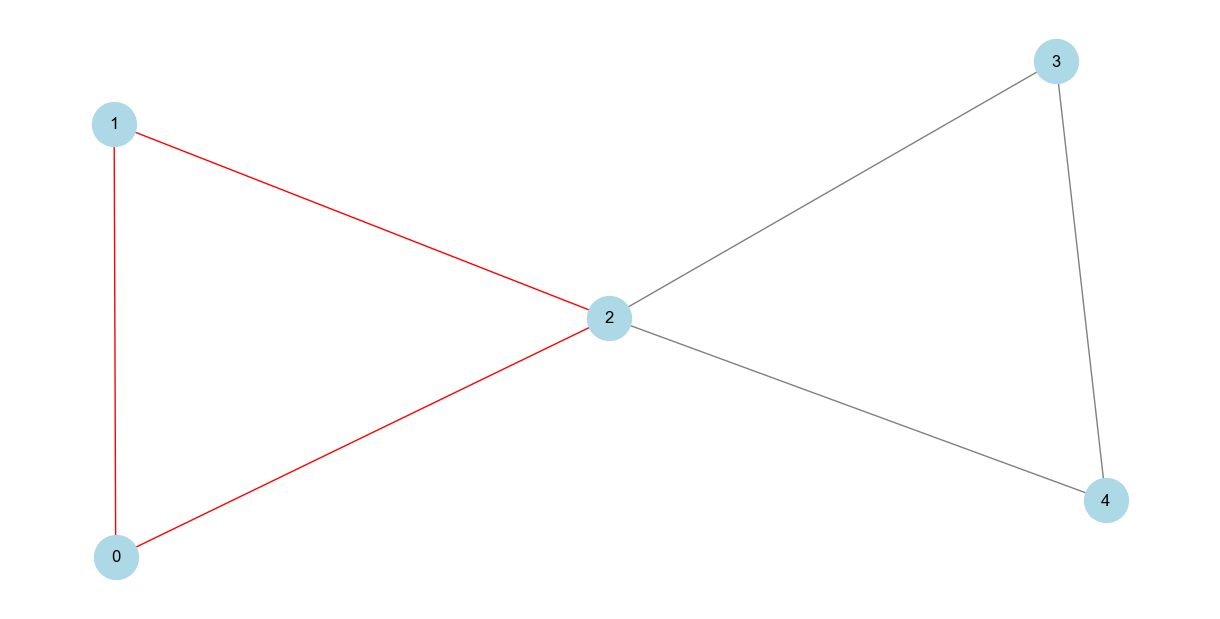

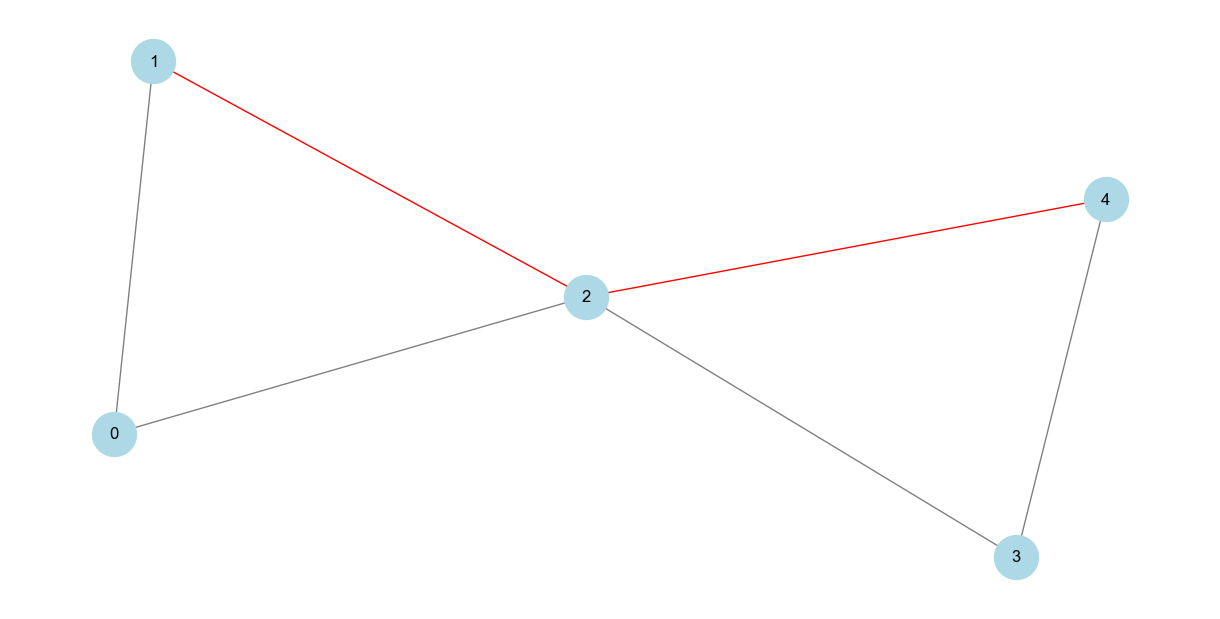

In [72]:
def find_2_node_paths(edge_list: List[Tuple[int, int]]) -> List[Tuple[int, int,int]]:
    """
    Find all 2-node paths in the graph represented by the edge list.
    A 2-node path is simply an edge (src, dst).
    """
    result = set()
    for src, dst in edge_list:
        for src2, dst2 in edge_list:
            if src2 == dst and dst2 != src:
                result.add(tuple(sorted((src, dst, dst2))))
    return list(result)

two_node_paths = sorted(find_2_node_paths(edge_list))
print(f"📊 Found {len(two_node_paths)} 2-node paths in the graph.")
print(f"First few 2-node paths: {two_node_paths[:5]}")
mpl_draw(data_graph, with_labels=True, node_size=1000, node_color='lightblue',
         edge_color=gen_edge_colors(data_graph, two_node_paths[0]))
plt.show()
mpl_draw(data_graph, with_labels=True, node_size=1000, node_color='lightblue',
         edge_color=gen_edge_colors(data_graph, two_node_paths[4]))
plt.show()


Ok now what if we want to find a cycle?
How about we take the 2-node paths and find all the edges that connect the start and end of those paths



📊 Found 2 cycles in the graph. Took: 0.042 ms
First cycle: [(0, 1, 2), (2, 3, 4)]


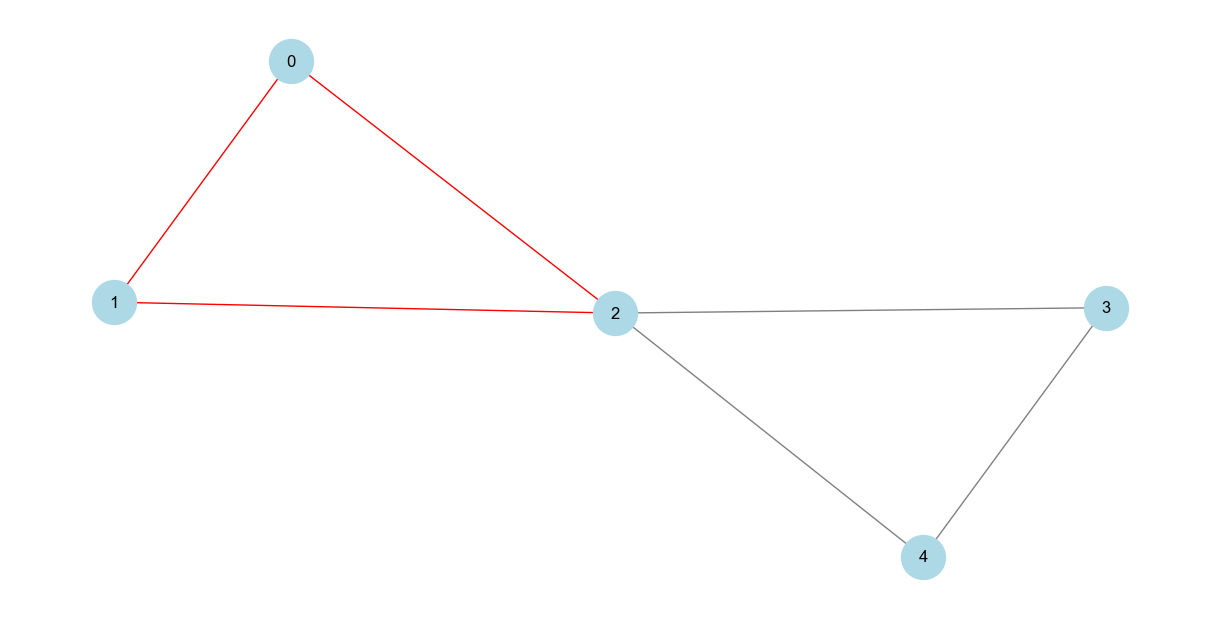

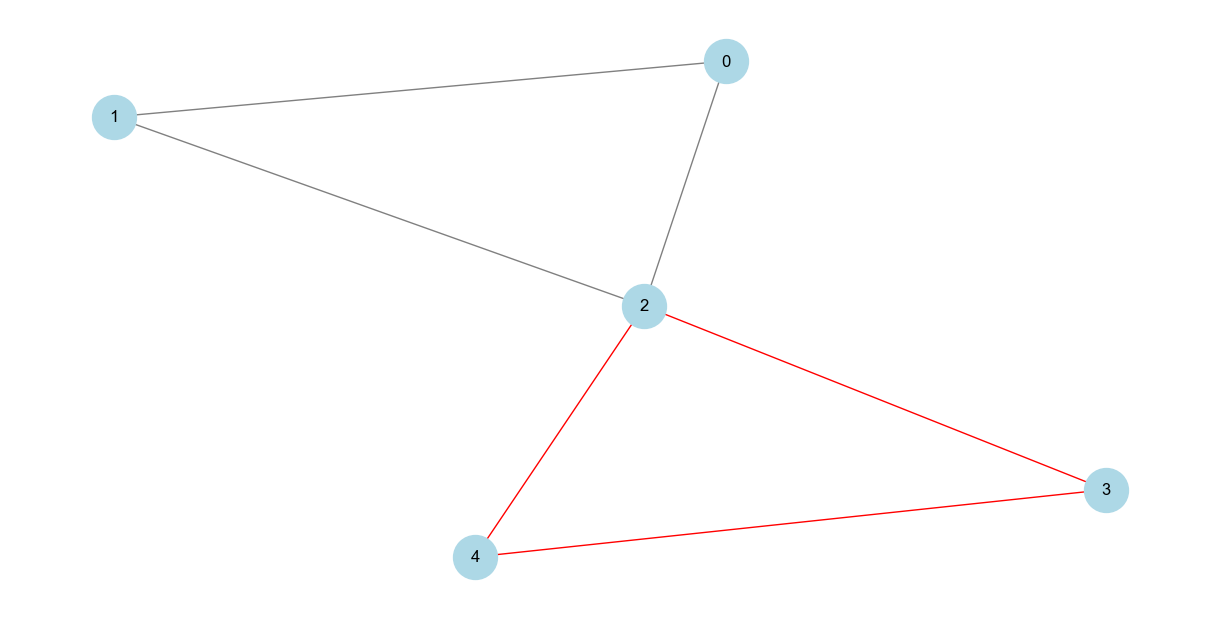

In [75]:
def find_cycles_from_paths(edge_list: List[Tuple[int, int]], paths: List[Tuple[int, int,int]]) -> List[Tuple[int, int,int]]:
    """
    Find all cycles in the graph by checking if the start and end of each path are connected.
    """
    edge_set = set(edge_list)
    cycles = []
    for src, mid, dst in paths:
        if (dst, src) in edge_set or (src, dst) in edge_set:
            cycles.append((src, mid, dst))
    return cycles

start = time()
cycles = find_cycles_from_paths(edge_list, two_node_paths)
elapsed =  time() - start
print(f"📊 Found {len(cycles)} cycles in the graph. Took: {elapsed*1000:.3f} ms")
print(f"First cycle: {cycles}")
for cycle in cycles:
    mpl_draw(data_graph, with_labels=True, node_size=1000, node_color='lightblue',
             edge_color=gen_edge_colors(data_graph, cycle))
    plt.show()

## Graphs as DataFrames
Now from the exercise above we see:
1. Finding 3-node path depended on the 2-node paths
2. We needed to iterate over the edge list multiple times applying some filtering

Idea: Can we apply this filtering all at once, SIMD style? First we need a datastructure for it

In [76]:
# Convert graph to DataFrame
def graph_to_dataframe(graph: rx.PyGraph) -> pd.DataFrame:
    """
    Convert a rustworkx graph to a pandas DataFrame.
    Each row represents an edge.
    """
    edges = graph.edge_list()
    df = pd.DataFrame(edges, columns=['src', 'dst'])
    return df

# Convert our example graph
edge_df = graph_to_dataframe(data_graph)

print("📊Graph as a DataFrame:")
print(edge_df.to_string(index=False))

📊Graph as a DataFrame:
 src  dst
   0    1
   1    2
   2    0
   2    3
   3    4
   4    2


### Finding Patterns with JOINs

**Key observation**: Finding a 3-hop path is just a JOIN operation!

```
Path: A → B → C

Step 1: Find all (A, B) edges
Step 2: Find all (B, C) edges
Step 3: JOIN A on B to get (A, B, C) paths
```

In [77]:
# Example: Find all 2-hop paths using JOIN
print("🔍 Finding 2-hop paths using DataFrame JOIN...\n")

def calculate_find_2hop(edges_data_frame) -> pd.DataFrame:
    # Self-join on the edge table
    # Join condition: dst of first edge == src of second edge
    paths_2hop = edges_data_frame.merge(
        edges_data_frame,
        left_on='dst',
        right_on='src',
        suffixes=('_1', '_2')
    )

    # Rename for clarity
    paths_2hop = paths_2hop[['src_1', 'dst_1', 'dst_2']]
    paths_2hop.columns = ['node_0', 'node_1', 'node_2']
    return paths_2hop

paths_2hop = calculate_find_2hop(edge_df)
print("2-hop paths")
print(paths_2hop.head(10))
print(f"\n✅ Found {len(paths_2hop)} total 2-hop paths")

# Example: Path 0 → 1 → 2
print("\nExample: Node 0 → Node 1 → Node 2 is a valid 2-hop path")

🔍 Finding 2-hop paths using DataFrame JOIN...

2-hop paths
   node_0  node_1  node_2
0       0       1       2
1       1       2       0
2       1       2       3
3       4       2       0
4       4       2       3
5       2       0       1
6       2       3       4
7       3       4       2

✅ Found 8 total 2-hop paths

Example: Node 0 → Node 1 → Node 2 is a valid 2-hop path


**Amazing!** We just found paths using a simple database JOIN! 🎉

No graph traversal, no recursion - just table operations.

## Extending the above
How can we extend this to find triangles?

In [78]:
def calculate_find_3hop(paths_2hop: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
    """
    Find all 3-hop paths by joining 2-hop paths with edges.
    """
    # Join 2-hop paths with edges
    paths_3hop = paths_2hop.merge(
        edge_df,
        left_on='node_2',
        right_on='src',
        suffixes=('_path', '_edge')
    )
    return paths_3hop
paths_3hop = calculate_find_3hop(paths_2hop, edge_df)
print("3-hop paths")
print(paths_3hop.head(10))
print(f"\n✅ Found {len(paths_3hop)} total 3-hop paths")

3-hop paths
   node_0  node_1  node_2  src  dst
0       0       1       2    2    0
1       0       1       2    2    3
2       3       4       2    2    0
3       3       4       2    2    3
4       1       2       0    0    1
5       4       2       0    0    1
6       1       2       3    3    4
7       4       2       3    3    4
8       2       0       1    1    2
9       2       3       4    4    2

✅ Found 10 total 3-hop paths


However the 3-hop paths include non-cycles as well.
We need to filter those out by checking if the start and end nodes are connected.

Filtered Cycles (Triangles):
   node_0  node_1  node_2  src  dst
0       0       1       2    2    0
3       3       4       2    2    3
4       1       2       0    0    1
7       4       2       3    3    4
8       2       0       1    1    2
9       2       3       4    4    2

✅ Found 2 triangles after filtering
{(0, 1, 2), (2, 3, 4)}


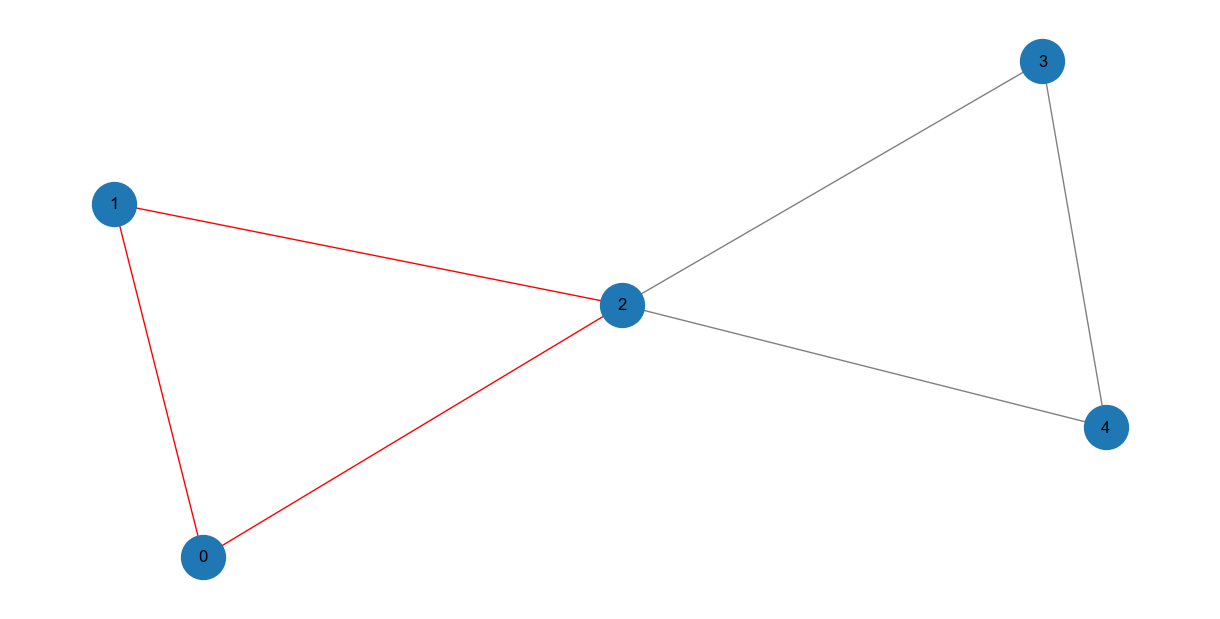

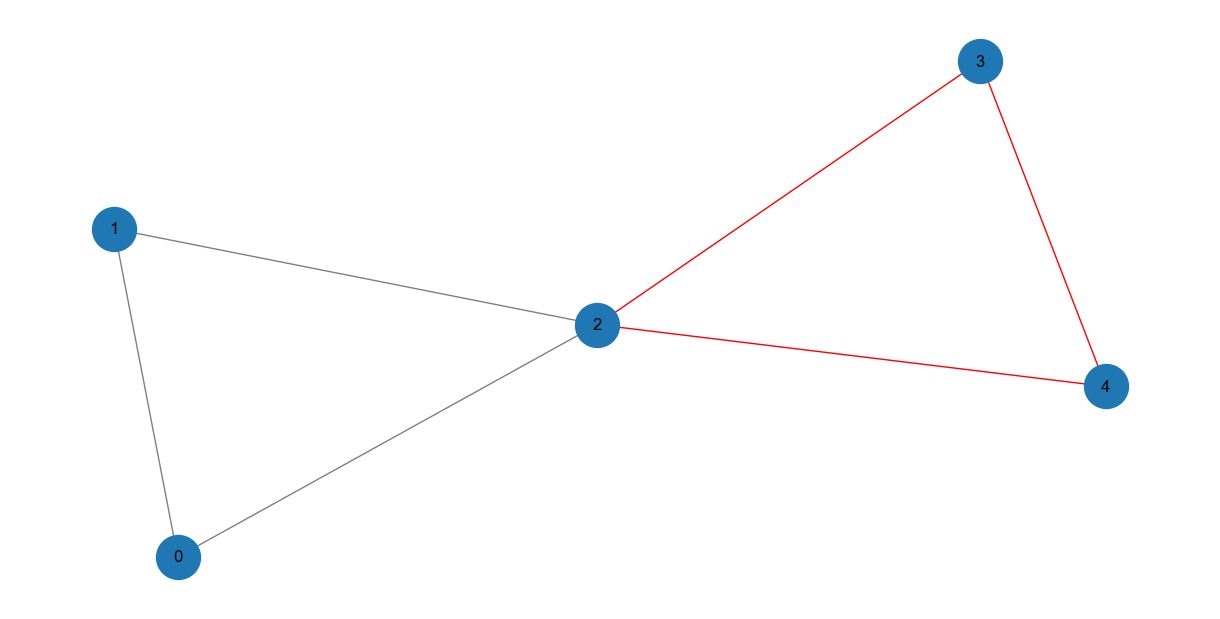

In [99]:
def filter_cycles(paths_3hop: pd.DataFrame) -> pd.DataFrame:
    """
    Filter 3-hop paths to find cycles (triangles).
    A cycle is when the start and end nodes are connected.
    """
    paths_3hop.drop(paths_3hop[paths_3hop['node_0'] != paths_3hop['dst']].index, inplace=True)
    return paths_3hop
cycles_df = filter_cycles(paths_3hop)
print("Filtered Cycles (Triangles):")
print(cycles_df.head(10))
results = {tuple(set(sorted(d.values()))) for d in cycles_df.to_dict('records')}
print(f"\n✅ Found {len(results)} triangles after filtering")
print(results)

for res in results:
    mpl_draw(data_graph, with_labels=True, node_size=1000,
             edge_color=gen_edge_colors(data_graph, list(res)))
    plt.show()



---
## 🎯 Exercise: Find 4-Hop Paths

Now that you've seen how to find 2-hop and 3-hop paths using JOINs, try finding **4-hop paths**!

**Key insight**: You already have a DataFrame with all 2-hop paths. A 4-hop path is just two 2-hop paths connected!

**Your task**:
1. Join the 2-hop paths DataFrame with itself
2. Match where the end of the first 2-hop connects to the start of the second 2-hop
3. Make sure you don't create loops (filter out paths where the end equals the start)

**Example**: If you have 2-hop paths (0→1→2) and (2→3→4), joining them gives 4-hop path (0→1→2→3→4)

In [ ]:
# We already have the 2-hop paths from earlier
print("📊 Available 2-hop paths DataFrame (paths_2hop):")
print(paths_2hop.head())
print(f"\nColumns: {list(paths_2hop.columns)}")
print(f"Total 2-hop paths: {len(paths_2hop)}\n")

# TODO: Join paths_2hop with itself to create 4-hop paths
# Hint: You want to match where node_2 of the first path equals node_0 of the second path
#
# paths_4hop = paths_2hop.merge(
#     paths_2hop,
#     left_on='???',      # Which column from the first DataFrame?
#     right_on='???',     # Which column from the second DataFrame?
#     suffixes=('_first', '_second')
# )

# TODO: Filter out loops (where the start equals the end)
# Hint: node_0_first should not equal node_2_second
# paths_4hop = paths_4hop[paths_4hop['???'] != paths_4hop['???']]

# TODO: Print your results
# print(f"✅ Found {len(paths_4hop)} total 4-hop paths")
# print("\nFirst few 4-hop paths:")
# print(paths_4hop.head(10))

---
## 7. Optional: GPU Acceleration with cuDF

If you have a GPU available, uncomment and run the cell below to see GPU performance!